# Advection-diffusion with finite differences

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg

## Diffusion test

First, let's do a test to make sure the diffusion part is working correctly, by evolving the Green's function using semi-implicit spectral and Crank-Nicholson and comparing with the analytic solution. (Note that we're using the Green's function for an unbounded/non-periodic domain, so it behaves differently at the boundaries and won't agree well for large times).

In [2]:
def gaussian(x, x0, t, D):
    # Green's function for the diffusion equation
    return np.exp(-(x-x0)**2/(4*D*t)) / np.sqrt(4*np.pi*D*t)

Using matplotlib backend: <object object at 0x106433180>
nsteps, dt, alpha, dx =  1612 6.203473945409429e-06 0.1 0.007874015748031496


2023-11-22 19:37:07.771 Python[30424:2117828] WARNING: Secure coding is not enabled for restorable state! Enable secure coding by implementing NSApplicationDelegate.applicationSupportsSecureRestorableState: and returning YES.
/opt/homebrew/lib/python3.11/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


<Figure size 1280x960 with 0 Axes>

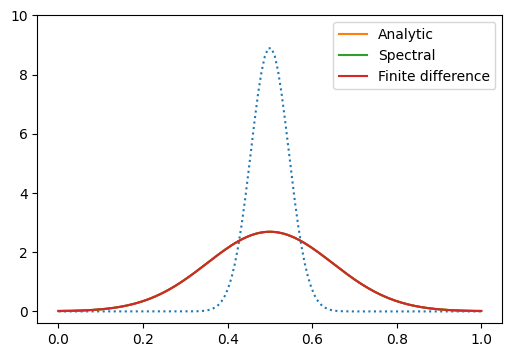

Errors:
Comparing numerical solutions:  0.001543398413265784
Finite difference vs analytic:  0.0077268785483977295
Spectral vs analytic:  0.007652185275836165


In [3]:
n = 128
x = np.linspace(0,1,n)
dx = x[1]-x[0]

# diffusion coefficient
D = 1

# time to integrate
T = 0.01

# timestep
alpha = 0.1
dt = alpha * (dx**2)/D

# Build the semi-implicit matrix update
aa = 0.5*alpha  ## we need 1/2 the timestep for each part
CC = np.diag(-aa*np.ones(n-1), k=-1) + np.diag(-aa*np.ones(n-1), k=1) + np.diag(2*aa*np.ones(n))
CC[0,-1] = -aa   # periodic boundaries
CC[-1,0] = -aa
AA = np.eye(n) - CC
Ainv = np.linalg.inv(np.eye(n) + CC)
Asemi = Ainv@AA

# initial condition
t0 = 1e-3
f = gaussian(x, 0.5, t0, D)

f_init = f.copy()
f1 = f.copy()

%matplotlib

g = np.fft.fft(f)
k = np.fft.fftfreq(n) * 2*np.pi/dx
J = complex(0,1)

nsteps = int(T/dt)
dt = T/nsteps
print("nsteps, dt, alpha, dx = ", nsteps, dt, alpha, dx)

for i in range(nsteps):

    # spectral update
    dg = - D*k*k
    # semi-implicit
    g = g * (1 + 0.5*dt*dg) / (1 - 0.5*dt*dg)

    # finite-difference update  
    # Crank-Nicholson
    f1 = Asemi@f1
    
    if i % int(nsteps/10) == 0 or i == nsteps-1:
        f = np.fft.ifft(g)
        plt.clf()
        plt.plot(x,f_init, ":")
        plt.plot(x, gaussian(x, 0.5, t0 + (i+1)*dt, D))
        plt.plot(x,np.real(f))
        plt.plot(x,np.real(f1), '--')
        plt.title('t=%.3lg' % (t0 + (i+1) * T/nsteps))
        plt.ylim((-0.4,10))
        plt.pause(1e-1)
 
%matplotlib inline
plt.clf()
plt.figure(figsize=((6,4)))
f = np.fft.ifft(g)
plt.plot(x,f_init, ":")
plt.plot(x, gaussian(x, 0.5, t0 + T, D), label='Analytic')
plt.plot(x, f, label='Spectral')
plt.plot(x, f1, label='Finite difference')
plt.ylim((-0.4,10))
plt.legend()
plt.show()

print("Errors:")
print("Comparing numerical solutions: ", np.max(np.abs(f1-f)))
print("Finite difference vs analytic: ", np.max(np.abs(f1-gaussian(x, 0.5, t0 + T, D))))
print("Spectral vs analytic: ",np.max(np.abs(f-gaussian(x, 0.5, t0 + T, D))))

## Now include advection

Now add in advection, using the 2nd order Lax-Wendroff scheme as the finite-difference update.

In [4]:
def do_integration(x, f, v, D, T, dt_frac, show_animation = False):

    n = len(x)
    dx = x[1]-x[0]

    # timestep
    dt1 = (dx**2)/(D + 1e-15)
    dt2 = dx/(abs(v) + 1e-15)
    dt = dt_frac * min(dt1,dt2)
    alpha = D*dt/dx**2
    beta = v*dt/dx

    # Build the semi-implicit matrix update for Crank-Nicholson
    aa = 0.5*alpha  ## we need 1/2 the timestep for each part
    CC = np.diag(-aa*np.ones(n-1), k=-1) + np.diag(-aa*np.ones(n-1), k=1) + np.diag(2*aa*np.ones(n))
    CC[0,-1] = -aa   # periodic boundaries
    CC[-1,0] = -aa
    AA = np.eye(n) - CC
    Ainv = np.linalg.inv(np.eye(n) + CC)
    Asemi = Ainv@AA

    f_init = f.copy()
    f1 = f.copy()

    if show_animation:
        %matplotlib

    g = np.fft.fft(f)
    k = np.fft.fftfreq(n) * 2*np.pi/dx
    J = complex(0,1)

    nsteps = int(T/dt)
    dt = T/nsteps
    if show_animation:
        print(nsteps, dt, alpha, dx, beta)

    for i in range(nsteps):

        # spectral update
        dg = -J*k*v - D*k*k
        # semi-implicit
        g = g * (1 + 0.5*dt*dg) / (1 - 0.5*dt*dg)

        # finite-difference update (operator split)

        # Lax-Wendroff 2nd order for advection
        fp = np.roll(f1,-1)
        fm = np.roll(f1,1)
        f1 = f1 - 0.5*beta * (fp-fm) + 0.5*beta**2 * (fp - 2*f1 + fm)

        # Crank-Nicholson for diffusion step
        f1 = Asemi@f1
    
        if show_animation:
            if i % 10 == 0 or i == nsteps-1:
                f = np.fft.ifft(g)
                plt.clf()
                plt.plot(x,f_init, ":")
                plt.plot(x,np.real(f))
                plt.plot(x,np.real(f1), '--')
                plt.title('t=%.3lg' % ((i+1) * T/nsteps))
                plt.ylim((-0.4,1.4))
                plt.pause(1e-4)
 
    if show_animation:
        %matplotlib inline
    f = np.fft.ifft(g)
    plt.plot(x,f_init, ":")
    plt.plot(x,f, label='Spectral')
    plt.plot(x,f1, label='Finite diff')
    #plt.ylim((-0.4,1.4))
    plt.legend(fontsize='x-small')

    if show_animation:
        print("Errors:")
        print("Comparing numerical solutions: ", np.max(np.abs(f1-f)))
        print("Finite difference vs initial: ", np.max(np.abs(f1-f_init)))
        print("Spectral vs initial: ",np.max(np.abs(f-f_init)))

In [5]:
def plot_row(v, D, dt_frac, T):
    n = 128
    # place the first grid point at 1/n rather than 0, 
    # then the advection time across the whole grid is 1/v
    x = np.linspace(1.0/n,1,n)

    plt.clf()
    plt.figure(figsize=((9,3)))
    plt.suptitle('D=%.1e, dt_frac=%lg' % (D, dt_frac))

    # Step
    plt.subplot(131)
    f = np.zeros_like(x)
    f[n//4:3*n//4] = 1
    do_integration(x, f, v, D, T, dt_frac)

    # Gaussian
    plt.subplot(132)
    f = np.exp(-(x-0.5)**2/0.1**2)
    do_integration(x, f, v, D, T, dt_frac)

    # sin
    plt.subplot(133)
    f = np.sin(2*np.pi*1.5*x)
    do_integration(x, f, v, D, T, dt_frac)

    plt.tight_layout()
    plt.show()

<Figure size 640x480 with 0 Axes>

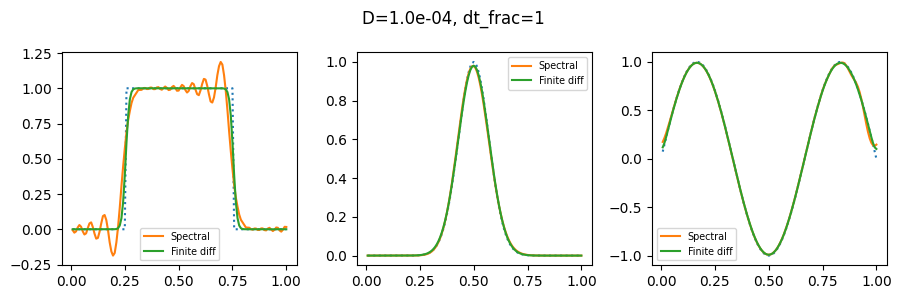

<Figure size 640x480 with 0 Axes>

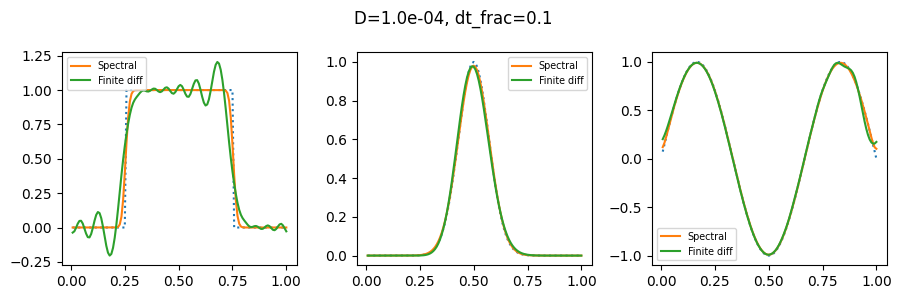

<Figure size 640x480 with 0 Axes>

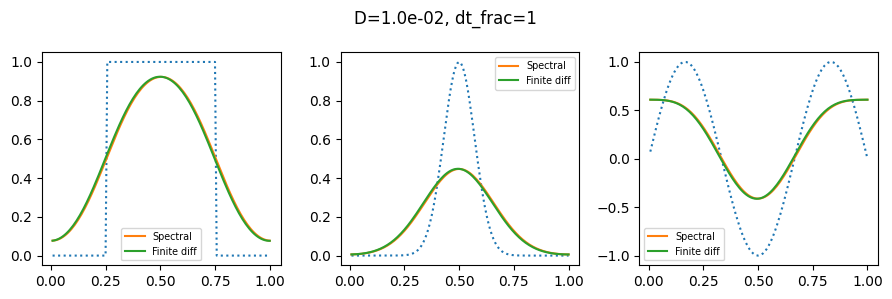

<Figure size 640x480 with 0 Axes>

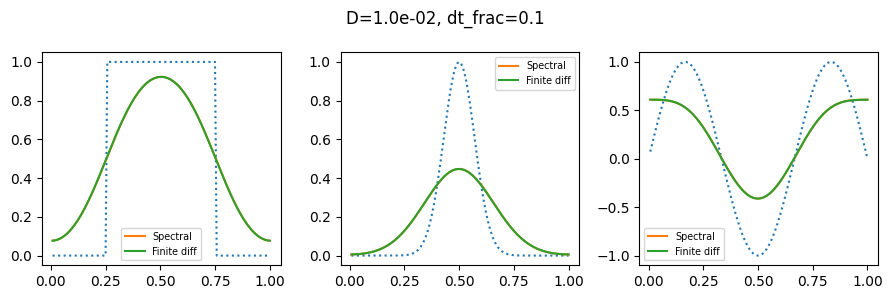

In [18]:
# plot_row(v, D, dt_frac, T)
plot_row(1, 1e-4, 1.0, 1)
plot_row(1, 1e-4, 0.1, 1)
plot_row(1, 1e-2, 1, 1)
plot_row(1, 1e-2, 0.1, 1)